# Last step of the stOrder workflow: combining GEX-based and physical space based distances b/w cell states to jointly derive the trajectory of invading trophoblast

02.2022, updated after bug fix

For the GEX part I am using cell state connectivities derived by PAGA (notebook S0) for invading trophoblast of donor P13 (SN + multiome atlas)

For the spatail part I am using spatial covariance values derived with the spatial covariance model (notebooks S1 and S2)
with all samples of donor P13 (SN+multiome) and donors P13, P14 and Hrv43 spatail data (relevant 8 chips)

There is an opportunity to subset the cell states that are present in each Visium chip (for instance, there are no VCT_CCC or GC in donor Hrv43 chip etc.), however even without this slightly manual intervention the inference works and manages to pinpoint the branching point population (EVT_2)

Considering only `myometrium` and `decidua_and_villi_tips` regions (based on tissue segmentation done with SpatialDE2 tissue segmenatation in `S1` notebook)

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import anndata

import scanpy as sc
import scipy
import matplotlib.pyplot as plt

In [2]:
sc.settings.set_figure_params(dpi=80)  # low dpi (dots per inch) yields small inline figures
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()

-----
anndata     0.7.5
scanpy      1.7.1
sinfo       0.3.1
-----
PIL                 8.1.2
anndata             0.7.5
anyio               NA
attr                20.3.0
babel               2.9.0
backcall            0.2.0
brotli              NA
cairo               1.20.0
certifi             2021.10.08
cffi                1.14.5
chardet             4.0.0
cloudpickle         1.6.0
colorama            0.4.4
cycler              0.10.0
cython_runtime      NA
cytoolz             0.11.0
dask                2021.03.1
dateutil            2.8.1
decorator           4.4.2
fsspec              0.8.7
get_version         2.1
google              NA
h5py                3.1.0
idna                2.10
igraph              0.8.3
ipykernel           5.5.0
ipython_genutils    0.2.0
ipywidgets          7.6.3
jedi                0.18.0
jinja2              2.11.3
joblib              1.0.1
json5               NA
jsonschema          3.2.0
jupyter_server      1.4.1
jupyterlab_server   2.3.0
kiwisolver          1.3.1


# 1. Reading in results of spatial covariance model (smooth proximity of cell states in physical space)

Using invading trophoblast densities derived from cell2location analysis projecting donor P13 states onto donors P13, P14 and Hrv43 Visium data

In [3]:
# Visium chip IDs
IDs = ['34914_WS_PLA_S9101764',
 '34914_WS_PLA_S9101765',
 '34914_WS_PLA_S9101766',
 '34914_WS_PLA_S9101767',
 '34882_WS_PLA_S9101769',
 '34882_WS_PLA_S9101770',
 '36173_Pla_HDBR9518710',
 '36173_Pla_Camb9518737']

In [4]:
# cell state tags of invading trophoblast from cell2location object

#cell_types = ['VCT_CCC', 'EVT_1', 'EVT_2', 'EVT_3', 'eEVT', 'iEVT', 'GC']
cell_types = ['w_sf_VCT_CCC_hybrid',
 'w_sf_EVT_1_hybrid',
 'w_sf_EVT_2_hybrid',
 'w_sf_eEVT_hybrid',
 'w_sf_iEVT_hybrid',
 'w_sf_GC_hybrid']

### Optional (skipping in the end): implementing per chip manual selection of cell states that are actually present in each chip (to eliminate anyd off-target mapping happening in cell2location analysis)

In [5]:
# cell states relevant for each slide - taking all results for all Visium chips

cell_states_of_interest = {}

for ID in IDs:
    print(ID)
    cell_states_of_interest[ID] = cell_types

34914_WS_PLA_S9101764
34914_WS_PLA_S9101765
34914_WS_PLA_S9101766
34914_WS_PLA_S9101767
34882_WS_PLA_S9101769
34882_WS_PLA_S9101770
36173_Pla_HDBR9518710
36173_Pla_Camb9518737


In [6]:
# 22.02.2022 results
# with new cell2location results for the full P13 atlas (with run_regression and pre-mRNA-aligned Visium)
# spot selection based on tissue segmentation of the chips into regions using SpatialDE2 (notebook S2)
# updated after bug fix

# with l_init = 29

# reading results for run with cell densities

results_ct_density = {}
corr_dfs_ct_density = {}

for ID in IDs:
    print(ID)
    results_ct_density[ID] = pd.read_csv('/nfs/team292/aa22/SpatialDE_colocation_model_related/results/20220222_SpatialDE_pairwise_corr_model_region_spot_selection_chip_' + ID + '_kernel_lenghtscales_29.csv', index_col=0)
    
    # removing unnecesary stuff from the cell type name
    #results_ct_density[ID]['ct1'] = [elem[5:-4] for elem in results_ct_density[ID]['ct1']]
    #results_ct_density[ID]['ct2'] = [elem[5:-4] for elem in results_ct_density[ID]['ct2']]

    corr_dfs_ct_density[ID] = pd.DataFrame(index = cell_states_of_interest[ID],
                       columns = cell_states_of_interest[ID])
    
    for row in list(results_ct_density[ID].index):
        curr_data = results_ct_density[ID].loc[row]
        curr_ct1 = results_ct_density[ID].loc[row]['ct1']
        curr_ct2 = results_ct_density[ID].loc[row]['ct2']
        curr_corr = results_ct_density[ID].loc[row]['cor']
    
        corr_dfs_ct_density[ID].loc[curr_ct1, curr_ct2] = curr_corr
        corr_dfs_ct_density[ID].loc[curr_ct2, curr_ct1] = curr_corr
        
    # for ease of eye inspection
    for ct in cell_types:
        corr_dfs_ct_density[ID].loc[ct,ct] = 0
        
        
    # subset to only those cell states that are relevant for each chip
    corr_dfs_ct_density[ID] = corr_dfs_ct_density[ID].loc[cell_states_of_interest[ID],cell_states_of_interest[ID]]

    corr_dfs_ct_density[ID] = corr_dfs_ct_density[ID].astype(float)

34914_WS_PLA_S9101764
34914_WS_PLA_S9101765
34914_WS_PLA_S9101766
34914_WS_PLA_S9101767
34882_WS_PLA_S9101769
34882_WS_PLA_S9101770
36173_Pla_HDBR9518710
36173_Pla_Camb9518737


In [7]:
def plot_heatmap(data_table):
    sns.heatmap(data_table, cmap='RdBu_r', vmax = max(abs(np.max(data_table.values)), abs(np.min(data_table.values))),
                center=0,
               #vmin = -max(abs(np.max(data_table.values)), abs(np.min(data_table.values))),
                #annot=True
               )

In [8]:
corr_dfs_ct_density['34882_WS_PLA_S9101769']

,w_sf_VCT_CCC_hybrid,w_sf_EVT_1_hybrid,w_sf_EVT_2_hybrid,w_sf_eEVT_hybrid,w_sf_iEVT_hybrid,w_sf_GC_hybrid
w_sf_VCT_CCC_hybrid,0.000000,-0.045626,-0.077723,-0.112905,-0.105404,0.161235
w_sf_EVT_1_hybrid,-0.045626,0.000000,0.138033,0.031226,-0.063888,-0.206554
w_sf_EVT_2_hybrid,-0.077723,0.138033,0.000000,0.043532,0.110027,-0.468164
w_sf_eEVT_hybrid,-0.112905,0.031226,0.043532,0.000000,0.021935,-0.145645
w_sf_iEVT_hybrid,-0.105404,-0.063888,0.110027,0.021935,0.000000,-0.130666
w_sf_GC_hybrid,0.161235,-0.206554,-0.468164,-0.145645,-0.130666,0.000000


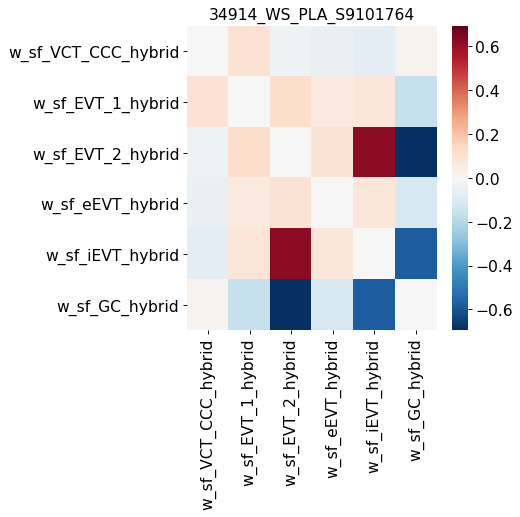

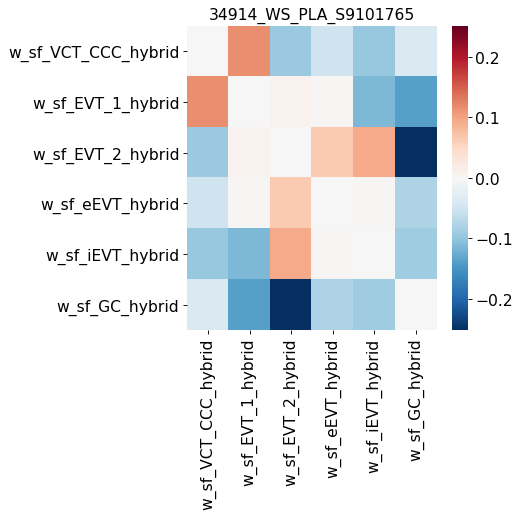

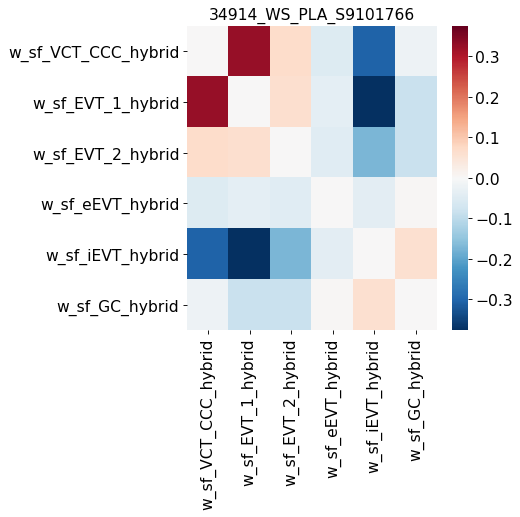

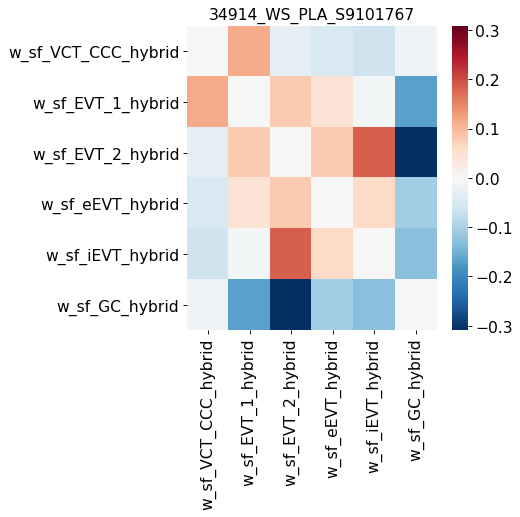

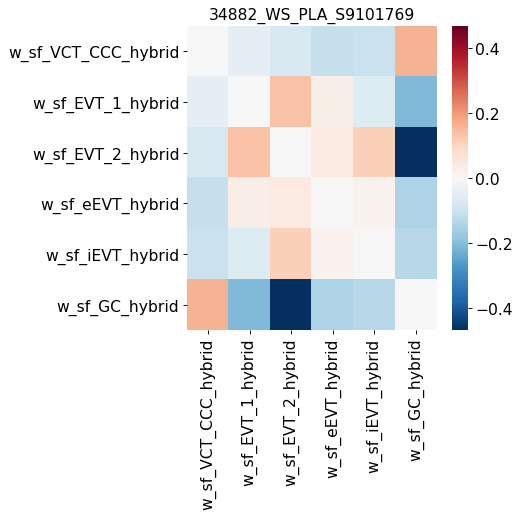

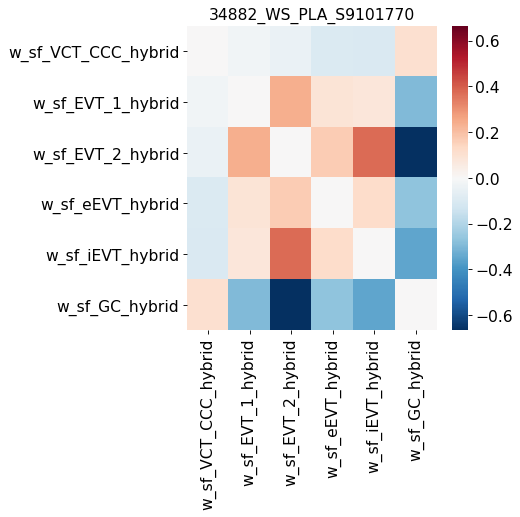

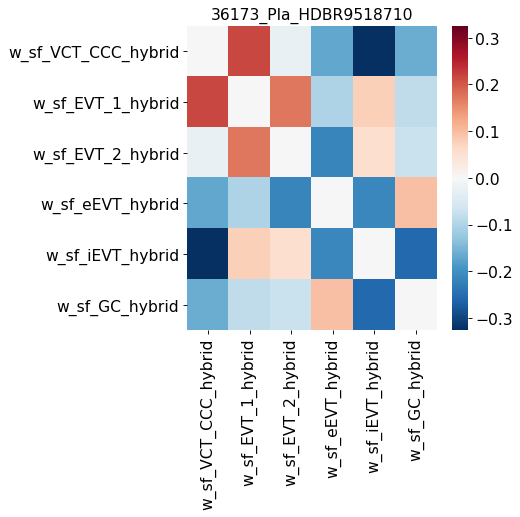

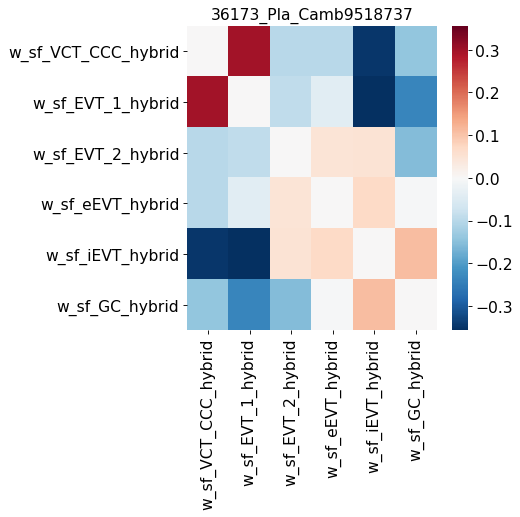

In [9]:
# l_init = 29
for ID in IDs:
    #print(ID)
    plt.figure(figsize=(5,5))
    plt.title(ID)
    plot_heatmap(corr_dfs_ct_density[ID])

In [10]:
IDs

['34914_WS_PLA_S9101764',
 '34914_WS_PLA_S9101765',
 '34914_WS_PLA_S9101766',
 '34914_WS_PLA_S9101767',
 '34882_WS_PLA_S9101769',
 '34882_WS_PLA_S9101770',
 '36173_Pla_HDBR9518710',
 '36173_Pla_Camb9518737']

In [11]:
# getting to a matrix of pairwise spatial covariance values for all invading trophoblast cell states
# here just summing up the matrices for all chips, later will scale the absolute values

corr_df_ct_density = corr_dfs_ct_density['34914_WS_PLA_S9101765'].add(corr_dfs_ct_density['34914_WS_PLA_S9101764'], fill_value=0)
corr_df_ct_density = corr_df_ct_density.add(corr_dfs_ct_density['34914_WS_PLA_S9101766'], fill_value=0)
corr_df_ct_density = corr_df_ct_density.add(corr_dfs_ct_density['34914_WS_PLA_S9101767'], fill_value=0)
corr_df_ct_density = corr_df_ct_density.add(corr_dfs_ct_density['34882_WS_PLA_S9101769'], fill_value=0)
corr_df_ct_density = corr_df_ct_density.add(corr_dfs_ct_density['34882_WS_PLA_S9101770'], fill_value=0)
corr_df_ct_density = corr_df_ct_density.add(corr_dfs_ct_density['36173_Pla_HDBR9518710'], fill_value=0)
corr_df_ct_density = corr_df_ct_density.add(corr_dfs_ct_density['36173_Pla_Camb9518737'], fill_value=0)

# to avoid numpy errors
corr_df_ct_density = corr_df_ct_density.astype(float)

In [12]:
# order cell states to inspect visually in a convenient way from VCT_CCC up to GC
ct_in_order = ['w_sf_VCT_CCC_hybrid','w_sf_EVT_1_hybrid','w_sf_EVT_2_hybrid','w_sf_eEVT_hybrid','w_sf_iEVT_hybrid','w_sf_GC_hybrid']

corr_df_ct_density = corr_df_ct_density.loc[ct_in_order,ct_in_order]

In [13]:
# for less busy plot
corr_df_ct_density.columns = ['VCT_CCC', 'EVT_1', 'EVT_2',
       'eEVT', 'iEVT', 'GC']
corr_df_ct_density.index = ['VCT_CCC', 'EVT_1', 'EVT_2',
       'eEVT', 'iEVT', 'GC']

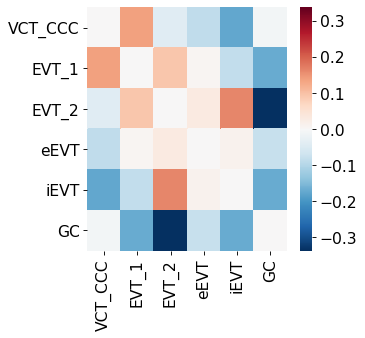

In [14]:
# 22.02.2022 results
# l_init = 29
# with NO manual limitations of the cell states
# all 8 chips

# dividing by 8 to scale for 8 chips, doesn't matter so much for now
plot_heatmap(corr_df_ct_density/8)

In [16]:
corr_df_ct_density

,VCT_CCC,EVT_1,EVT_2,eEVT,iEVT,GC
VCT_CCC,0.000000,1.108752,-0.334121,-0.681527,-1.409788,-0.079831
EVT_1,1.108752,0.000000,0.747748,0.057207,-0.662590,-1.365174
EVT_2,-0.334121,0.747748,0.000000,0.248317,1.316112,-2.694997
eEVT,-0.681527,0.057207,0.248317,0.000000,0.109936,-0.617177
iEVT,-1.409788,-0.662590,1.316112,0.109936,0.000000,-1.359038
GC,-0.079831,-1.365174,-2.694997,-0.617177,-1.359038,0.000000


# 2. Reading in results of PAGA (GEX-based connectivities of cell states)

Using results of PAGA on donor P13 SN + multiome RNA-seq data (using all donors data did not yield great results here)

### Reading fully analysed invading trophoblast dataset (SN + multiome) with computed PAGA graph

In [17]:
save_path = '/lustre/scratch117/cellgen/team292/aa22/adata_objects/202007_snRNA-seq_MFI/snRNA_seq_MFI_202007_adatas/202012_FINAL_reanalysis_with_souporcell_deconvolution_common_variants/donor_P13_all_samples_analysis_202110/'

In [18]:
adata_PAGA = sc.read(save_path + 'adata_inv_troph_final_with_PAGA_20211123_corrected_annotation.h5ad')

In [19]:
adata_PAGA

AnnData object with n_obs × n_vars = 4715 × 29058
    obs: 'n_genes', 'donor', 'tissue_block', 'age', 'sample', 'percent_mito', 'n_counts', 'dataset', 'technique', 'scrublet_score', 'scrublet_cluster_score', 'bh_pval', 'batch', 'is_doublet', 'barcode_sample_copy', 'barcode', 'souporcell_assignment', 'inter_ind_doublet', 'S_score', 'G2M_score', 'phase', 'annotation_prev', 'louvain', 'is_doublet_propagate', 'origin_M_F', 'annotation_prev_or_removed', 'louvain_scvi_n_latent_20', 'louvain_scvi_n_latent_8', 'x', 'y', 'z', 'dot_size', 'louvain_scvi_n_latent_20_R', 'annot_inv_troph', 'louvain_scvi_n_latent_8_R', 'louvain_scvi_n_latent_8_RR', 'annot_inv_troph_n_latent_8', 'prelim_annot_scvi_c2l_tested', 'louvain_scvi_n_latent_30', 'louvain_scvi_n_latent_30_R', 'annot_inv_troph_n_latent_30', 'annot_inv_troph_n_latent_8_corrected'
    var: 'gene_ids-0', 'feature_types-0', 'genome-0', 'n_cells-0', 'gene_ids-1', 'feature_types-1', 'genome-1', 'n_cells-1', 'gene_ids-2', 'feature_types-2', 'genome-2

In [20]:
# getting more distinct colors for the zoomed in plot (donor P13 all troph)

colors_final = ['#EE2724', # EVT_1
                '#F58C74', # EVT_2
                '#726658', # GC
                #'#BC80B8', # SCT
                #'#81B2D3', # VCT
                '#88CDAF', # VCT_CCC
                #'#514C89', # VCT_fusing
                #'#3A5337', # VCT_p
                '#21479E', # eEVT
                '#FEEC6E', # iEVT
               ]

In [21]:
curr_embedding_key = 'X_umap_scVI_n_latent_8_sample'

In [22]:
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

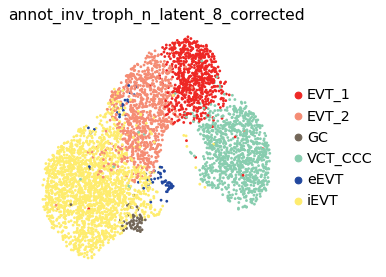

In [23]:
sc.pl.embedding(adata_PAGA, curr_embedding_key,
                color=['annot_inv_troph_n_latent_8_corrected'], 
                palette = colors_final, frameon=False,
           save='_inv_troph_manifold_P13.pdf')

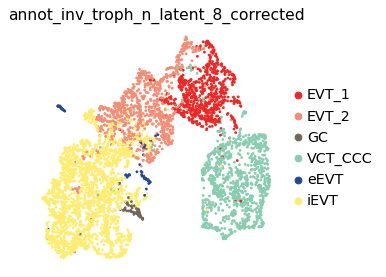

In [24]:
sc.pl.umap(adata_PAGA,
                color=['annot_inv_troph_n_latent_8_corrected'], 
                palette = colors_final, frameon=False,
           save='_inv_troph_PAGA_denoised_manifold_P13.pdf')

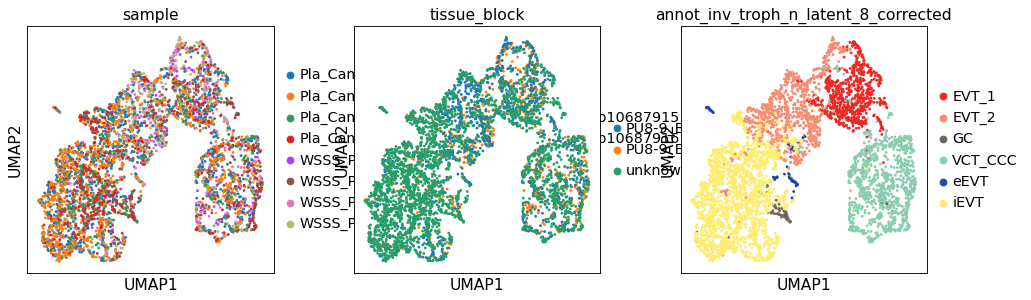

In [25]:
sc.pl.umap(adata_PAGA,color=['sample','tissue_block','annot_inv_troph_n_latent_8_corrected'], 
           #save='_inv_troph_PAGA_GEX_graph.pdf'
          )

In [26]:
adata_PAGA

AnnData object with n_obs × n_vars = 4715 × 29058
    obs: 'n_genes', 'donor', 'tissue_block', 'age', 'sample', 'percent_mito', 'n_counts', 'dataset', 'technique', 'scrublet_score', 'scrublet_cluster_score', 'bh_pval', 'batch', 'is_doublet', 'barcode_sample_copy', 'barcode', 'souporcell_assignment', 'inter_ind_doublet', 'S_score', 'G2M_score', 'phase', 'annotation_prev', 'louvain', 'is_doublet_propagate', 'origin_M_F', 'annotation_prev_or_removed', 'louvain_scvi_n_latent_20', 'louvain_scvi_n_latent_8', 'x', 'y', 'z', 'dot_size', 'louvain_scvi_n_latent_20_R', 'annot_inv_troph', 'louvain_scvi_n_latent_8_R', 'louvain_scvi_n_latent_8_RR', 'annot_inv_troph_n_latent_8', 'prelim_annot_scvi_c2l_tested', 'louvain_scvi_n_latent_30', 'louvain_scvi_n_latent_30_R', 'annot_inv_troph_n_latent_30', 'annot_inv_troph_n_latent_8_corrected'
    var: 'gene_ids-0', 'feature_types-0', 'genome-0', 'n_cells-0', 'gene_ids-1', 'feature_types-1', 'genome-1', 'n_cells-1', 'gene_ids-2', 'feature_types-2', 'genome-2

#### Visualising how PAGA graph looks for figures (only GEX-based trajectory)

--> added 'pos', the PAGA positions (adata.uns['paga'])


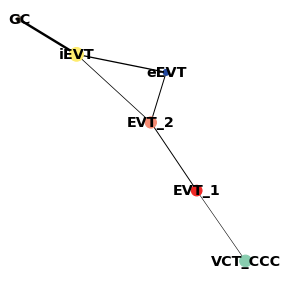

In [27]:
sc.pl.paga(adata_PAGA, color=['annot_inv_troph_n_latent_8_corrected'], 
           edge_width_scale=0.5, node_size_scale=0.6, threshold=0.1, random_state=0,
          frameon=False,
          save='_PAGA_GEX_only.pdf')

--> added 'pos', the PAGA positions (adata.uns['paga'])


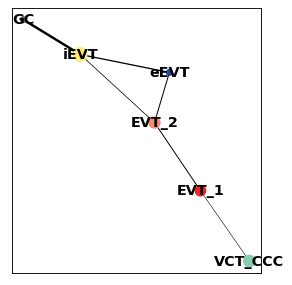

In [28]:
sc.pl.paga(adata_PAGA, color=['annot_inv_troph_n_latent_8_corrected'], 
           edge_width_scale=0.5, node_size_scale=0.6, threshold=0.13, random_state=0)

In [29]:
adata_PAGA

AnnData object with n_obs × n_vars = 4715 × 29058
    obs: 'n_genes', 'donor', 'tissue_block', 'age', 'sample', 'percent_mito', 'n_counts', 'dataset', 'technique', 'scrublet_score', 'scrublet_cluster_score', 'bh_pval', 'batch', 'is_doublet', 'barcode_sample_copy', 'barcode', 'souporcell_assignment', 'inter_ind_doublet', 'S_score', 'G2M_score', 'phase', 'annotation_prev', 'louvain', 'is_doublet_propagate', 'origin_M_F', 'annotation_prev_or_removed', 'louvain_scvi_n_latent_20', 'louvain_scvi_n_latent_8', 'x', 'y', 'z', 'dot_size', 'louvain_scvi_n_latent_20_R', 'annot_inv_troph', 'louvain_scvi_n_latent_8_R', 'louvain_scvi_n_latent_8_RR', 'annot_inv_troph_n_latent_8', 'prelim_annot_scvi_c2l_tested', 'louvain_scvi_n_latent_30', 'louvain_scvi_n_latent_30_R', 'annot_inv_troph_n_latent_30', 'annot_inv_troph_n_latent_8_corrected'
    var: 'gene_ids-0', 'feature_types-0', 'genome-0', 'n_cells-0', 'gene_ids-1', 'feature_types-1', 'genome-1', 'n_cells-1', 'gene_ids-2', 'feature_types-2', 'genome-2

--> added 'pos', the PAGA positions (adata.uns['paga'])


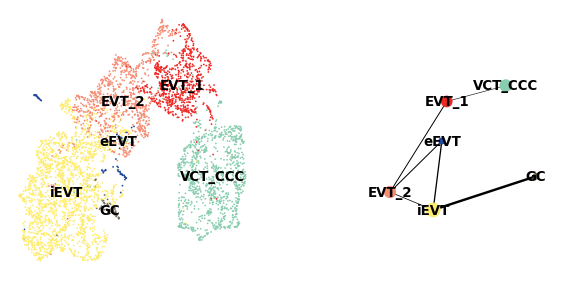

In [30]:
axs = sc.pl.paga_compare(
    adata_PAGA, title='', right_margin=0.3, size=10,
    threshold=0.05, edge_width_scale=0.5, node_size_scale=0.6, random_state=0,
    legend_fontsize=12, fontsize=50, frameon=False, save=True)

# 3. Combining GEX-based and physical space-based connectivities b/w invading trophoblast cell states to jointly derive invading trophoblast trajectory

### sc.tl.paga that has been run on adata_PAGA returns the following:

 - `connectivities`: numpy.ndarray (adata.uns['paga'][‘connectivities’])
 
The full adjacency matrix of the abstracted graph, weights correspond to confidence in the connectivities of partitions.

 - `connectivities_tree`: scipy.sparse.csr_matrix (adata.uns['paga'][‘connectivities_tree’])
 
The adjacency matrix of the tree-like subgraph that best explains the topology.


For more please see [documentation](https://scanpy.readthedocs.io/en/stable/api/scanpy.tl.paga.html)


In [31]:
# 7 cell states of invading trophobalst
np.unique(adata_PAGA.obs['annot_inv_troph_n_latent_8_corrected'])

array(['EVT_1', 'EVT_2', 'GC', 'VCT_CCC', 'eEVT', 'iEVT'], dtype=object)

In [32]:
adata_PAGA.uns['paga']

{'connectivities': <6x6 sparse matrix of type '<class 'numpy.float64'>'
 	with 22 stored elements in Compressed Sparse Row format>,
 'connectivities_tree': <6x6 sparse matrix of type '<class 'numpy.float64'>'
 	with 5 stored elements in Compressed Sparse Row format>,
 'groups': 'annot_inv_troph_n_latent_8_corrected',
 'pos': array([[ 3.140659  ,  7.190815  ],
        [-2.6860545 ,  0.38263425],
        [12.300603  ,  1.5673517 ],
        [ 9.204392  ,  8.38012   ],
        [ 2.637301  ,  4.221141  ],
        [ 1.7494507 , -0.96191216]], dtype=float32)}

In [33]:
adata_PAGA.uns['paga']['connectivities'].todense()

matrix([[0.        , 0.23241445, 0.        , 0.13447446, 0.        ,
         0.00737118],
        [0.23241445, 0.        , 0.        , 0.01659596, 0.24168795,
         0.17695637],
        [0.        , 0.        , 0.        , 0.00861338, 0.        ,
         0.58348132],
        [0.13447446, 0.01659596, 0.00861338, 0.        , 0.00703628,
         0.0121416 ],
        [0.        , 0.24168795, 0.        , 0.00703628, 0.        ,
         0.30855971],
        [0.00737118, 0.17695637, 0.58348132, 0.0121416 , 0.30855971,
         0.        ]])

In [34]:
np.unique(adata_PAGA.obs['annot_inv_troph_n_latent_8_corrected'])

array(['EVT_1', 'EVT_2', 'GC', 'VCT_CCC', 'eEVT', 'iEVT'], dtype=object)

In [35]:
# order:
# 0 - EVT_1
# 1 - EVT_2
# 3 - GC
# 4 - VCT_CCC
# 5 - eEVT
# 6 - iEVT

# Working with cluster connectivities

In [36]:
# to understand the order of cell states in PAGA graph
connectivities_paga = pd.DataFrame(data = adata_PAGA.uns['paga']['connectivities'].todense(),
                                   columns = np.unique(adata_PAGA.obs['annot_inv_troph_n_latent_8']),
                                   index = np.unique(adata_PAGA.obs['annot_inv_troph_n_latent_8']))
connectivities_paga

,EVT_1,EVT_2,GC,VCT_CCC,eEVT,iEVT
EVT_1,0.000000,0.232414,0.000000,0.134474,0.000000,0.007371
EVT_2,0.232414,0.000000,0.000000,0.016596,0.241688,0.176956
GC,0.000000,0.000000,0.000000,0.008613,0.000000,0.583481
VCT_CCC,0.134474,0.016596,0.008613,0.000000,0.007036,0.012142
eEVT,0.000000,0.241688,0.000000,0.007036,0.000000,0.308560
iEVT,0.007371,0.176956,0.583481,0.012142,0.308560,0.000000


# Combining PAGA-derived cluster connectivities and Spatial Covariance model-derived distances into 1 metric

In [37]:
corr_df_ct_density

,VCT_CCC,EVT_1,EVT_2,eEVT,iEVT,GC
VCT_CCC,0.000000,1.108752,-0.334121,-0.681527,-1.409788,-0.079831
EVT_1,1.108752,0.000000,0.747748,0.057207,-0.662590,-1.365174
EVT_2,-0.334121,0.747748,0.000000,0.248317,1.316112,-2.694997
eEVT,-0.681527,0.057207,0.248317,0.000000,0.109936,-0.617177
iEVT,-1.409788,-0.662590,1.316112,0.109936,0.000000,-1.359038
GC,-0.079831,-1.365174,-2.694997,-0.617177,-1.359038,0.000000


In [38]:
# disregard negative values from spatial covariance matrix since we operate with connectivities here
# or trying to use values that can be interpreted as "how close the 2 cell states are in space? (with smooth transitions of density)"
corr_df_ct_density_nonneg = corr_df_ct_density.clip(lower=0)

In [39]:
# handle negative values separately?
corr_df_ct_density_nonneg

,VCT_CCC,EVT_1,EVT_2,eEVT,iEVT,GC
VCT_CCC,0.000000,1.108752,0.000000,0.000000,0.000000,0.0
EVT_1,1.108752,0.000000,0.747748,0.057207,0.000000,0.0
EVT_2,0.000000,0.747748,0.000000,0.248317,1.316112,0.0
eEVT,0.000000,0.057207,0.248317,0.000000,0.109936,0.0
iEVT,0.000000,0.000000,1.316112,0.109936,0.000000,0.0
GC,0.000000,0.000000,0.000000,0.000000,0.000000,0.0


### plotting this matrix for figure making

In [40]:
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

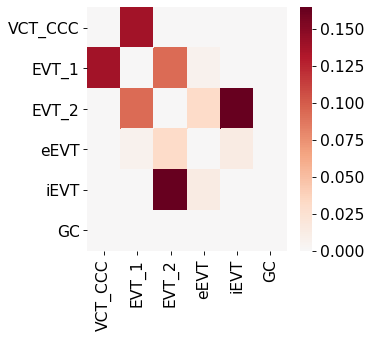

In [42]:
# for figure making - UPDATED
plot_heatmap(corr_df_ct_density_nonneg/8)
plt.savefig('./figures/20220222_sp_cov_heatmap_for_Fig2A.pdf', bbox_inches='tight')

### Scaling both tables (from PAGA and spatial covariance model) to the same abs max so that the values are comparable

In [43]:
# let's try to scale both tables to the same abs max so that the values are comparable
np.max(corr_df_ct_density_nonneg.values)

1.3161116435652447

In [44]:
np.min(corr_df_ct_density_nonneg.values)

0.0

In [45]:
np.max(connectivities_paga.values)

0.5834813244372389

In [46]:
np.min(connectivities_paga.values)

0.0

In [47]:
connectivities_paga = connectivities_paga * np.max(corr_df_ct_density_nonneg.values) / np.max(connectivities_paga.values)

In [48]:
np.max(connectivities_paga.values)

1.3161116435652447

In [49]:
corr_df_ct_density_nonneg

,VCT_CCC,EVT_1,EVT_2,eEVT,iEVT,GC
VCT_CCC,0.000000,1.108752,0.000000,0.000000,0.000000,0.0
EVT_1,1.108752,0.000000,0.747748,0.057207,0.000000,0.0
EVT_2,0.000000,0.747748,0.000000,0.248317,1.316112,0.0
eEVT,0.000000,0.057207,0.248317,0.000000,0.109936,0.0
iEVT,0.000000,0.000000,1.316112,0.109936,0.000000,0.0
GC,0.000000,0.000000,0.000000,0.000000,0.000000,0.0


# There is an argument `solid_edges` in sc.pl.paga() that can take custom connectivity edges to plot instead of the default adata.uns['paga']['connectivities'] - use this and pass joint connectivity metric

In [50]:
def calculate_combined_connectivities(df_paga_conn,
                              df_spatial_conn,
                              w = 0.3 # weight / significance of GEX distances in the overall distances - before it was for spatial
                             ):
    # calculate matrix of eucledian distances b/w centroids of cell types
    
    n_cell_types = df_paga_conn.shape[0]
    
    #print('n_cell_types', n_cell_types)
    
    cell_type_list = df_paga_conn.index
    
    #print('cell_type_list', cell_type_list)
    
    dist_mtx = np.zeros([n_cell_types, n_cell_types])
    
    #print(dist_mtx)
    
    for i in range(n_cell_types):
        #print('i:', i)
        
        for j in range(i):
            
            #print('j:', j)
            
            #print(cell_type_list[i], cell_type_list[j])
                        
            # (1-w)*(paga part) + w*(spatial part)
            dist_mtx[i][j] = df_paga_conn.loc[cell_type_list[i], cell_type_list[j]]*(w) + df_spatial_conn.loc[cell_type_list[i], cell_type_list[j]]*(1-w)
            
            #print('element in paga table:', df_paga_conn.loc[cell_type_list[i], cell_type_list[j]])
            #print('element in df_spatial_conn table:', df_spatial_conn.loc[cell_type_list[i], cell_type_list[j]])
            #print('vaue added:', dist_mtx[i][j])
            
            dist_mtx[j][i] = dist_mtx[i][j]
            
            #print('element', i, j, 'done (',cell_type_list[i],',',cell_type_list[j],')')
            
    dataframe = pd.DataFrame(data=dist_mtx, 
                             columns=cell_type_list,
                             index=cell_type_list)
    return(dataframe)    
    
    

In [51]:
ct_in_order = ['VCT_CCC','EVT_1','EVT_2','eEVT','iEVT','GC']
connectivities_paga = connectivities_paga.loc[ct_in_order,ct_in_order]

In [52]:
connectivities_paga

,VCT_CCC,EVT_1,EVT_2,eEVT,iEVT,GC
VCT_CCC,0.000000,0.303323,0.037434,0.015871,0.027387,0.019429
EVT_1,0.303323,0.000000,0.524238,0.000000,0.016627,0.000000
EVT_2,0.037434,0.524238,0.000000,0.545156,0.399146,0.000000
eEVT,0.015871,0.000000,0.545156,0.000000,0.695993,0.000000
iEVT,0.027387,0.016627,0.399146,0.695993,0.000000,1.316112
GC,0.019429,0.000000,0.000000,0.000000,1.316112,0.000000


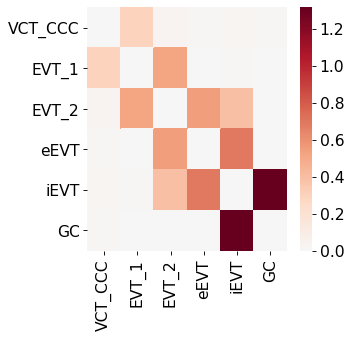

In [54]:
# saving this plot for making figure 2A - same as before
plot_heatmap(connectivities_paga)
plt.savefig('./figures/20220222_paga_gex_conn_heatmap_for_Fig2A.pdf', bbox_inches='tight')

In [55]:
corr_df_ct_density_nonneg

,VCT_CCC,EVT_1,EVT_2,eEVT,iEVT,GC
VCT_CCC,0.000000,1.108752,0.000000,0.000000,0.000000,0.0
EVT_1,1.108752,0.000000,0.747748,0.057207,0.000000,0.0
EVT_2,0.000000,0.747748,0.000000,0.248317,1.316112,0.0
eEVT,0.000000,0.057207,0.248317,0.000000,0.109936,0.0
iEVT,0.000000,0.000000,1.316112,0.109936,0.000000,0.0
GC,0.000000,0.000000,0.000000,0.000000,0.000000,0.0


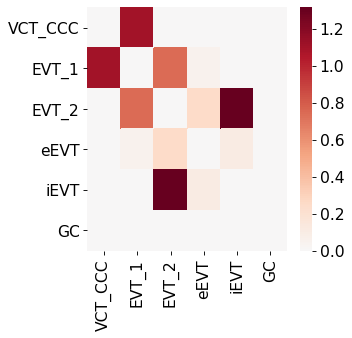

In [57]:
# with NO manual cell type constraints per chip
# 22.02.2021 results
plot_heatmap(corr_df_ct_density_nonneg)

In [58]:
# for different values of w - weight for spatial part
combined_connectivities = {}

w_values = [np.round(i*0.01, 2) for i in range(101)]

for w_value in w_values:
    #print(w_value)
    combined_connectivities['w_' + str(w_value)] = {}
    
    combined_connectivities['w_' + str(w_value)] = calculate_combined_connectivities(connectivities_paga, 
                                                                                     corr_df_ct_density_nonneg,
                                                                                                 w = w_value)
    
    # ordering columns and rows for consistency as they are ordered by np.unique
    #col_row_order = ['VCT_CCC', 'EVT_1', 'EVT_2', 'EVT_3', 'eEVT', 'iEVT', 'GC']
    col_row_order = list(np.unique(adata_PAGA.obs['annot_inv_troph_n_latent_8']))
    combined_connectivities['w_' + str(w_value)] = combined_connectivities['w_' + str(w_value)].loc[col_row_order, col_row_order]
    
    #combined_connectivities['w_' + str(w_value)].to_csv('./20210131_cell_type_connectivity_matrix_invading_trophoblast_donor_P13_combined_metric_w_' + str(w_value) + '.csv')
    

In [59]:
combined_connectivities.keys()

dict_keys(['w_0.0', 'w_0.01', 'w_0.02', 'w_0.03', 'w_0.04', 'w_0.05', 'w_0.06', 'w_0.07', 'w_0.08', 'w_0.09', 'w_0.1', 'w_0.11', 'w_0.12', 'w_0.13', 'w_0.14', 'w_0.15', 'w_0.16', 'w_0.17', 'w_0.18', 'w_0.19', 'w_0.2', 'w_0.21', 'w_0.22', 'w_0.23', 'w_0.24', 'w_0.25', 'w_0.26', 'w_0.27', 'w_0.28', 'w_0.29', 'w_0.3', 'w_0.31', 'w_0.32', 'w_0.33', 'w_0.34', 'w_0.35', 'w_0.36', 'w_0.37', 'w_0.38', 'w_0.39', 'w_0.4', 'w_0.41', 'w_0.42', 'w_0.43', 'w_0.44', 'w_0.45', 'w_0.46', 'w_0.47', 'w_0.48', 'w_0.49', 'w_0.5', 'w_0.51', 'w_0.52', 'w_0.53', 'w_0.54', 'w_0.55', 'w_0.56', 'w_0.57', 'w_0.58', 'w_0.59', 'w_0.6', 'w_0.61', 'w_0.62', 'w_0.63', 'w_0.64', 'w_0.65', 'w_0.66', 'w_0.67', 'w_0.68', 'w_0.69', 'w_0.7', 'w_0.71', 'w_0.72', 'w_0.73', 'w_0.74', 'w_0.75', 'w_0.76', 'w_0.77', 'w_0.78', 'w_0.79', 'w_0.8', 'w_0.81', 'w_0.82', 'w_0.83', 'w_0.84', 'w_0.85', 'w_0.86', 'w_0.87', 'w_0.88', 'w_0.89', 'w_0.9', 'w_0.91', 'w_0.92', 'w_0.93', 'w_0.94', 'w_0.95', 'w_0.96', 'w_0.97', 'w_0.98', 'w_0.99',

In [60]:
combined_connectivities['w_0.4']

,EVT_1,EVT_2,GC,VCT_CCC,eEVT,iEVT
EVT_1,0.000000,0.658344,0.000000,0.786580,0.034324,0.006651
EVT_2,0.658344,0.000000,0.000000,0.014974,0.367052,0.949325
GC,0.000000,0.000000,0.000000,0.007771,0.000000,0.526445
VCT_CCC,0.786580,0.014974,0.007771,0.000000,0.006348,0.010955
eEVT,0.034324,0.367052,0.000000,0.006348,0.000000,0.344359
iEVT,0.006651,0.949325,0.526445,0.010955,0.344359,0.000000


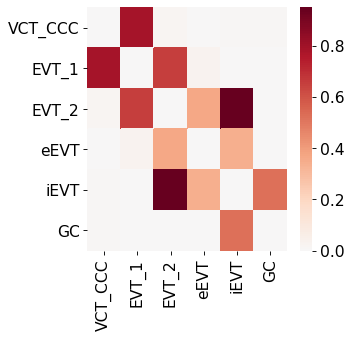

In [61]:
# plotting for making figure 2A - UPDATED
plot_heatmap(combined_connectivities['w_0.4'].loc[ct_in_order, ct_in_order])
plt.savefig('./figures/20220222_combined_heatmap_w_gex_0.4_for_Fig2A.pdf', bbox_inches = 'tight')

In [62]:
# adding these connectivities to adata.uns['paga'] to visualise later
for w_value in w_values:
    #print(w_value)
    curr_mtx_sparse = scipy.sparse.csr_matrix(combined_connectivities['w_' + str(w_value)].values)
    adata_PAGA.uns['paga']['combined_connectivities_w_gex_' + str(w_value)] = curr_mtx_sparse

In [63]:
adata_PAGA.uns['paga']['combined_connectivities_w_gex_0.0']

<6x6 sparse matrix of type '<class 'numpy.float64'>'
	with 12 stored elements in Compressed Sparse Row format>

In [64]:
pd.DataFrame(adata_PAGA.uns['paga']['combined_connectivities_w_gex_0.0'].todense())

,0,1,2,3,4,5
0,0.000000,0.747748,0.0,1.108752,0.057207,0.000000
1,0.747748,0.000000,0.0,0.000000,0.248317,1.316112
2,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
3,1.108752,0.000000,0.0,0.000000,0.000000,0.000000
4,0.057207,0.248317,0.0,0.000000,0.000000,0.109936
5,0.000000,1.316112,0.0,0.000000,0.109936,0.000000


In [65]:
pd.DataFrame(adata_PAGA.uns['paga']['combined_connectivities_w_gex_0.9'].todense())

,0,1,2,3,4,5
0,0.000000,0.546589,0.000000,0.383866,0.005721,0.014964
1,0.546589,0.000000,0.000000,0.033691,0.515472,0.490843
2,0.000000,0.000000,0.000000,0.017486,0.000000,1.184500
3,0.383866,0.033691,0.017486,0.000000,0.014284,0.024648
4,0.005721,0.515472,0.000000,0.014284,0.000000,0.637387
5,0.014964,0.490843,1.184500,0.024648,0.637387,0.000000


In [66]:
pd.DataFrame(adata_PAGA.uns['paga']['combined_connectivities_w_gex_0.6'].todense())

,0,1,2,3,4,5
0,0.000000,0.613642,0.000000,0.625495,0.022883,0.009976
1,0.613642,0.000000,0.000000,0.022460,0.426420,0.765932
2,0.000000,0.000000,0.000000,0.011657,0.000000,0.789667
3,0.625495,0.022460,0.011657,0.000000,0.009523,0.016432
4,0.022883,0.426420,0.000000,0.009523,0.000000,0.461570
5,0.009976,0.765932,0.789667,0.016432,0.461570,0.000000


In [67]:
adata_PAGA.uns['annot_inv_troph_n_latent_8_corrected_colors']

['#ee2724', '#f58c74', '#726658', '#88cdaf', '#21479e', '#feec6e']

In [68]:
adata_PAGA.uns['annot_inv_troph_n_latent_8_corrected_colors'] = ['#7edeb6', # EVT_1 - need to change
                '#bc80bd', # EVT_2 - need to change
                '#003dad', # GC - need to change
                '#ded97e', # VCT_CCC
                '#FF1200', # eEVT
                '#ffed6f', # iEVT - need to change
               ]

--> added 'pos', the PAGA positions (adata.uns['paga'])


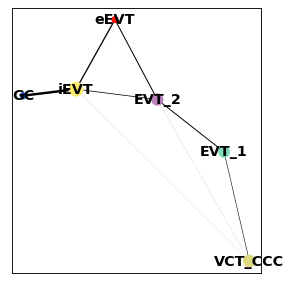

In [69]:
# original paga connectivities (only GEX-based)
sc.pl.paga(adata_PAGA, color=['annot_inv_troph_n_latent_8_corrected'], solid_edges='connectivities',
           edge_width_scale=0.5, node_size_scale=0.6, threshold=0.01, random_state=0)

### in the next few cells I am trying to play with the `threshold` argument to see if I can get rid of nodes that would make this graph **ACYCLIC**, connected and with 1 branching point

And if what I see doesn't have 2 known endpoints - eEVT & GC - then I go and refine it adding spatial connectivities with different coefficients

In [70]:
adata_PAGA.uns['annot_inv_troph_n_latent_8_corrected_colors'] = colors_final

--> added 'pos', the PAGA positions (adata.uns['paga'])


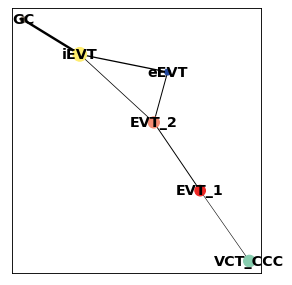

In [71]:
# original paga connectivities 
sc.pl.paga(adata_PAGA, color=['annot_inv_troph_n_latent_8_corrected'], solid_edges='connectivities',
           edge_width_scale=0.5, node_size_scale=0.6, threshold=0.02, random_state=0)

--> added 'pos', the PAGA positions (adata.uns['paga'])


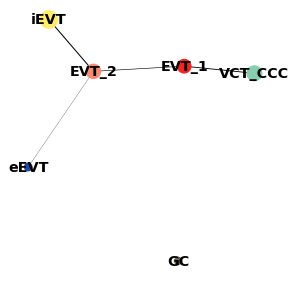

In [72]:
# with 22.02.2022 results with l_init = 29
sc.pl.paga(adata_PAGA, color=['annot_inv_troph_n_latent_8_corrected'], solid_edges='combined_connectivities_w_gex_0.1',
           edge_width_scale=0.1, node_size_scale=1, threshold=0.2, random_state=0,
          frameon=False, 
          )

--> added 'pos', the PAGA positions (adata.uns['paga'])


0.0
here link b/w eEVT and EVT_2 is stronger than b/w eEVT and iEVT


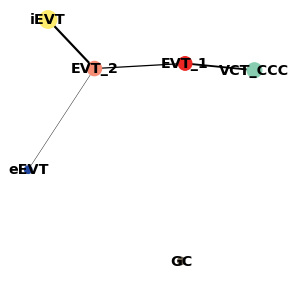

--> added 'pos', the PAGA positions (adata.uns['paga'])




0.01
here link b/w eEVT and EVT_2 is stronger than b/w eEVT and iEVT


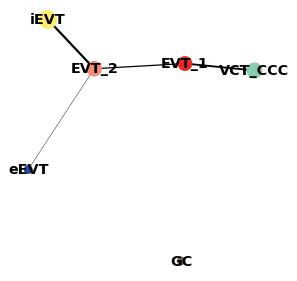

--> added 'pos', the PAGA positions (adata.uns['paga'])




0.02
here link b/w eEVT and EVT_2 is stronger than b/w eEVT and iEVT


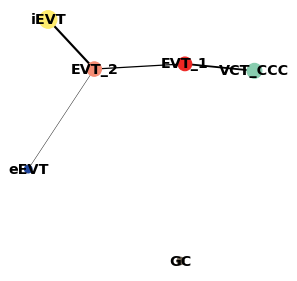

--> added 'pos', the PAGA positions (adata.uns['paga'])




0.03
here link b/w eEVT and EVT_2 is stronger than b/w eEVT and iEVT


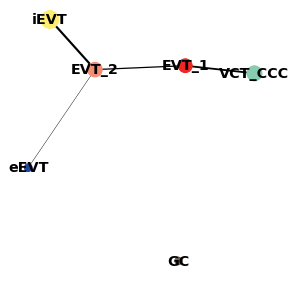

--> added 'pos', the PAGA positions (adata.uns['paga'])




0.04
here link b/w eEVT and EVT_2 is stronger than b/w eEVT and iEVT


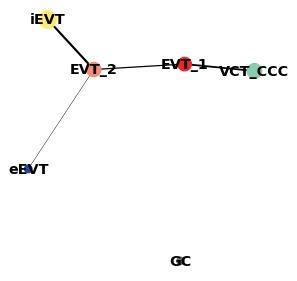

--> added 'pos', the PAGA positions (adata.uns['paga'])




0.05
here link b/w eEVT and EVT_2 is stronger than b/w eEVT and iEVT


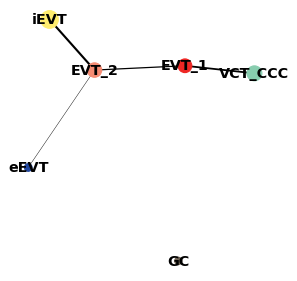

--> added 'pos', the PAGA positions (adata.uns['paga'])




0.06
here link b/w eEVT and EVT_2 is stronger than b/w eEVT and iEVT


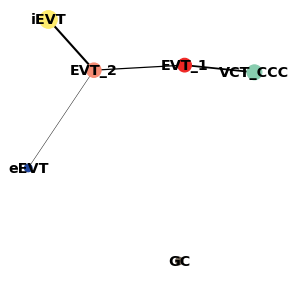

--> added 'pos', the PAGA positions (adata.uns['paga'])




0.07
here link b/w eEVT and EVT_2 is stronger than b/w eEVT and iEVT


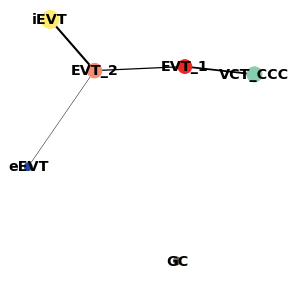

--> added 'pos', the PAGA positions (adata.uns['paga'])




0.08
here link b/w eEVT and EVT_2 is stronger than b/w eEVT and iEVT


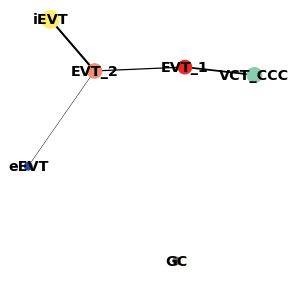

--> added 'pos', the PAGA positions (adata.uns['paga'])




0.09
here link b/w eEVT and EVT_2 is stronger than b/w eEVT and iEVT


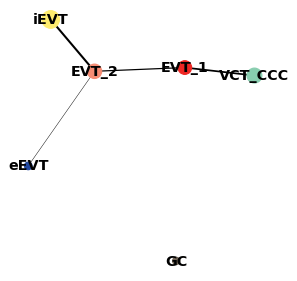

--> added 'pos', the PAGA positions (adata.uns['paga'])




0.1
here link b/w eEVT and EVT_2 is stronger than b/w eEVT and iEVT


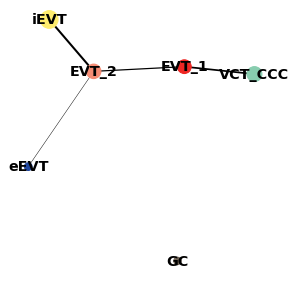

--> added 'pos', the PAGA positions (adata.uns['paga'])




0.11
here link b/w eEVT and EVT_2 is stronger than b/w eEVT and iEVT


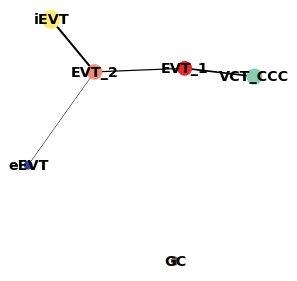

--> added 'pos', the PAGA positions (adata.uns['paga'])




0.12
here link b/w eEVT and EVT_2 is stronger than b/w eEVT and iEVT


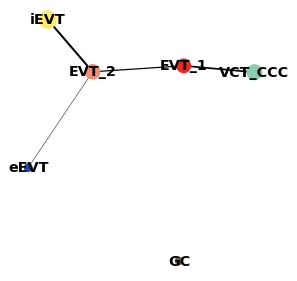

--> added 'pos', the PAGA positions (adata.uns['paga'])




0.13
here link b/w eEVT and EVT_2 is stronger than b/w eEVT and iEVT


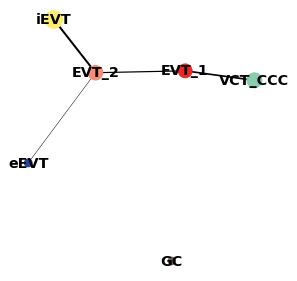

--> added 'pos', the PAGA positions (adata.uns['paga'])




0.14
here link b/w eEVT and EVT_2 is stronger than b/w eEVT and iEVT


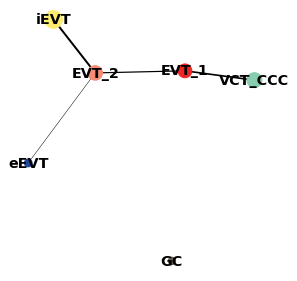

--> added 'pos', the PAGA positions (adata.uns['paga'])




0.15
here link b/w eEVT and EVT_2 is stronger than b/w eEVT and iEVT


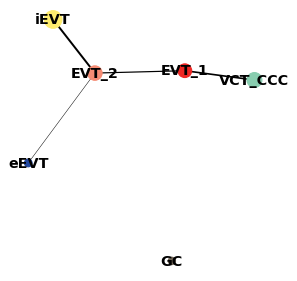

--> added 'pos', the PAGA positions (adata.uns['paga'])




0.16
here link b/w eEVT and EVT_2 is stronger than b/w eEVT and iEVT
this tree be visualised in the correct topology without GC being detached


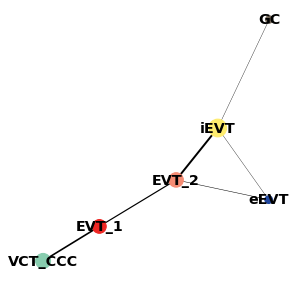

--> added 'pos', the PAGA positions (adata.uns['paga'])




0.17
here link b/w eEVT and EVT_2 is stronger than b/w eEVT and iEVT
this tree be visualised in the correct topology without GC being detached


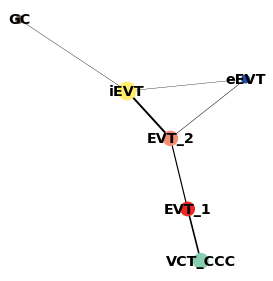

--> added 'pos', the PAGA positions (adata.uns['paga'])




0.18
here link b/w eEVT and EVT_2 is stronger than b/w eEVT and iEVT
this tree be visualised in the correct topology without GC being detached


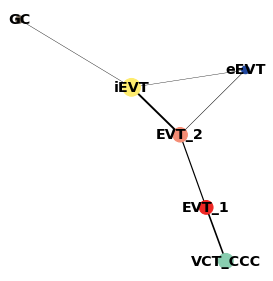



0.19
here link b/w eEVT and EVT_2 is stronger than b/w eEVT and iEVT
this tree be visualised in the correct topology without GC being detached


--> added 'pos', the PAGA positions (adata.uns['paga'])


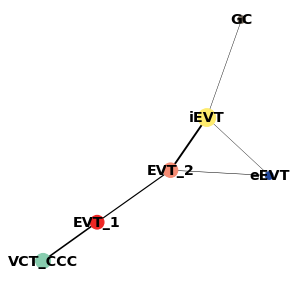

--> added 'pos', the PAGA positions (adata.uns['paga'])




0.2
here link b/w eEVT and EVT_2 is stronger than b/w eEVT and iEVT
this tree be visualised in the correct topology without GC being detached


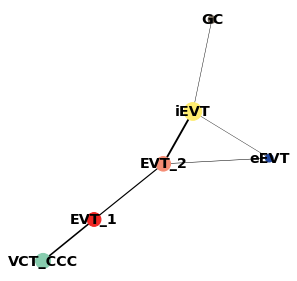

--> added 'pos', the PAGA positions (adata.uns['paga'])




0.21
here link b/w eEVT and EVT_2 is stronger than b/w eEVT and iEVT
this tree be visualised in the correct topology without GC being detached


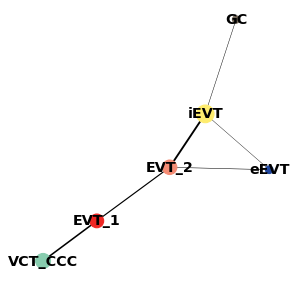

--> added 'pos', the PAGA positions (adata.uns['paga'])




0.22
here link b/w eEVT and EVT_2 is stronger than b/w eEVT and iEVT
this tree be visualised in the correct topology without GC being detached


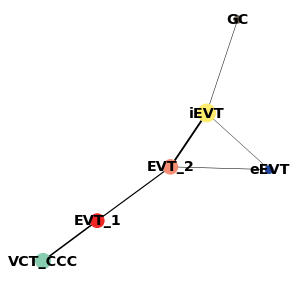

--> added 'pos', the PAGA positions (adata.uns['paga'])




0.23
here link b/w eEVT and EVT_2 is stronger than b/w eEVT and iEVT
this tree be visualised in the correct topology without GC being detached


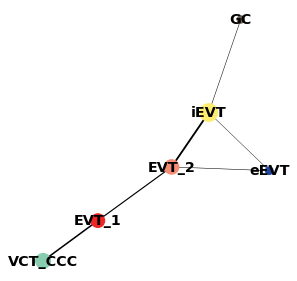

--> added 'pos', the PAGA positions (adata.uns['paga'])




0.24
here link b/w eEVT and EVT_2 is stronger than b/w eEVT and iEVT
this tree be visualised in the correct topology without GC being detached


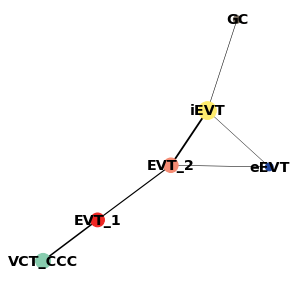

--> added 'pos', the PAGA positions (adata.uns['paga'])




0.25
here link b/w eEVT and EVT_2 is stronger than b/w eEVT and iEVT
this tree be visualised in the correct topology without GC being detached


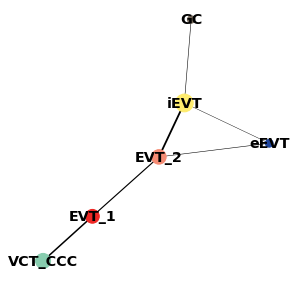

--> added 'pos', the PAGA positions (adata.uns['paga'])




0.26
here link b/w eEVT and EVT_2 is stronger than b/w eEVT and iEVT
this tree be visualised in the correct topology without GC being detached


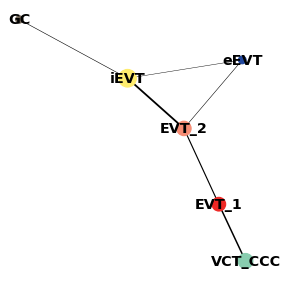

--> added 'pos', the PAGA positions (adata.uns['paga'])




0.27
here link b/w eEVT and EVT_2 is stronger than b/w eEVT and iEVT
this tree be visualised in the correct topology without GC being detached


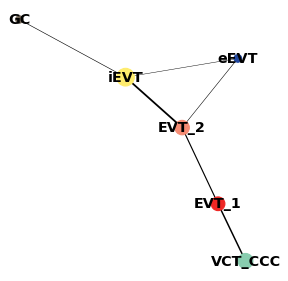

--> added 'pos', the PAGA positions (adata.uns['paga'])




0.28
here link b/w eEVT and EVT_2 is stronger than b/w eEVT and iEVT
this tree be visualised in the correct topology without GC being detached


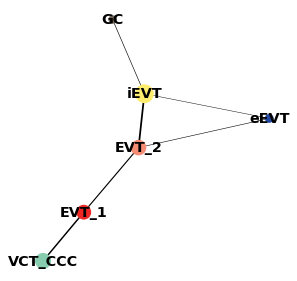

--> added 'pos', the PAGA positions (adata.uns['paga'])




0.29
here link b/w eEVT and EVT_2 is stronger than b/w eEVT and iEVT
this tree be visualised in the correct topology without GC being detached


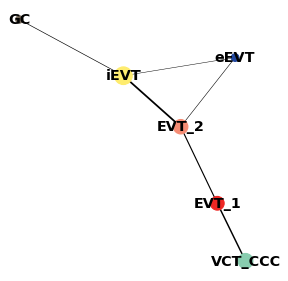

--> added 'pos', the PAGA positions (adata.uns['paga'])




0.3
here link b/w eEVT and EVT_2 is stronger than b/w eEVT and iEVT
this tree be visualised in the correct topology without GC being detached


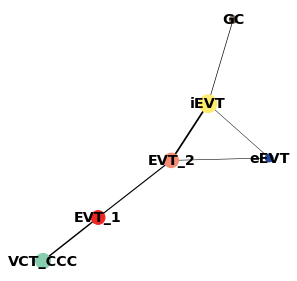

--> added 'pos', the PAGA positions (adata.uns['paga'])




0.31
here link b/w eEVT and EVT_2 is stronger than b/w eEVT and iEVT
this tree be visualised in the correct topology without GC being detached


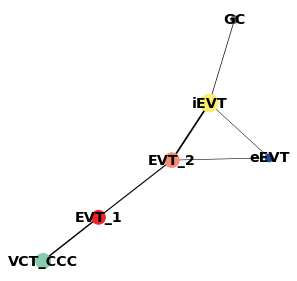

--> added 'pos', the PAGA positions (adata.uns['paga'])




0.32
here link b/w eEVT and EVT_2 is stronger than b/w eEVT and iEVT
this tree be visualised in the correct topology without GC being detached


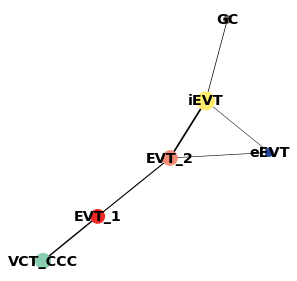

--> added 'pos', the PAGA positions (adata.uns['paga'])




0.33
here link b/w eEVT and EVT_2 is stronger than b/w eEVT and iEVT
this tree be visualised in the correct topology without GC being detached


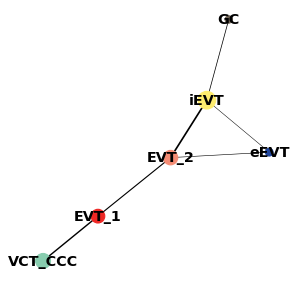

--> added 'pos', the PAGA positions (adata.uns['paga'])




0.34
here link b/w eEVT and EVT_2 is stronger than b/w eEVT and iEVT
this tree be visualised in the correct topology without GC being detached


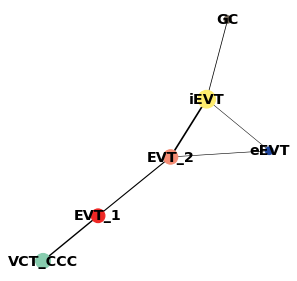

--> added 'pos', the PAGA positions (adata.uns['paga'])




0.35
here link b/w eEVT and EVT_2 is stronger than b/w eEVT and iEVT
this tree be visualised in the correct topology without GC being detached


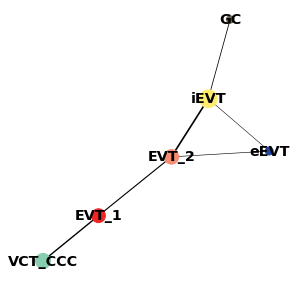

--> added 'pos', the PAGA positions (adata.uns['paga'])




0.36
here link b/w eEVT and EVT_2 is stronger than b/w eEVT and iEVT
this tree be visualised in the correct topology without GC being detached


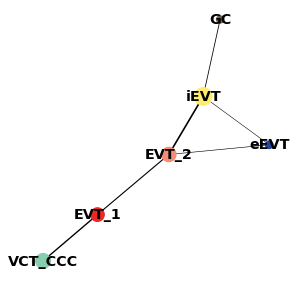

--> added 'pos', the PAGA positions (adata.uns['paga'])




0.37
here link b/w eEVT and EVT_2 is stronger than b/w eEVT and iEVT
this tree be visualised in the correct topology without GC being detached


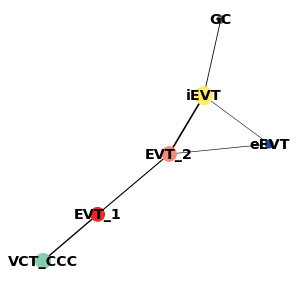

--> added 'pos', the PAGA positions (adata.uns['paga'])




0.38
here link b/w eEVT and EVT_2 is stronger than b/w eEVT and iEVT
this tree be visualised in the correct topology without GC being detached


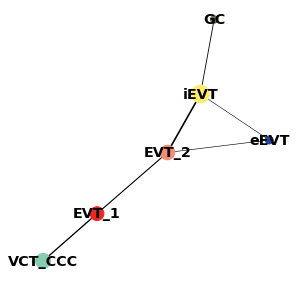

--> added 'pos', the PAGA positions (adata.uns['paga'])




0.39
here link b/w eEVT and EVT_2 is stronger than b/w eEVT and iEVT
this tree be visualised in the correct topology without GC being detached


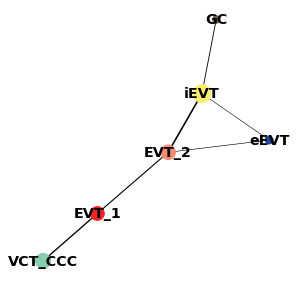

--> added 'pos', the PAGA positions (adata.uns['paga'])




0.4
here link b/w eEVT and EVT_2 is stronger than b/w eEVT and iEVT
this tree be visualised in the correct topology without GC being detached


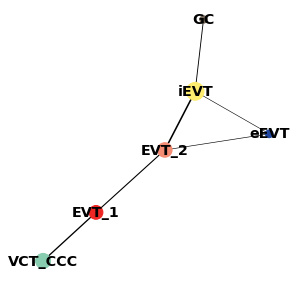

--> added 'pos', the PAGA positions (adata.uns['paga'])




0.41
here link b/w eEVT and EVT_2 is stronger than b/w eEVT and iEVT
this tree be visualised in the correct topology without GC being detached


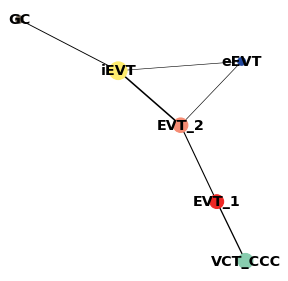

--> added 'pos', the PAGA positions (adata.uns['paga'])




0.42
here link b/w eEVT and EVT_2 is stronger than b/w eEVT and iEVT
this tree be visualised in the correct topology without GC being detached


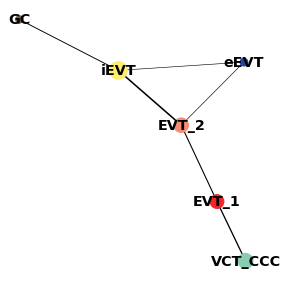

--> added 'pos', the PAGA positions (adata.uns['paga'])




0.43
here link b/w eEVT and EVT_2 is stronger than b/w eEVT and iEVT
this tree be visualised in the correct topology without GC being detached


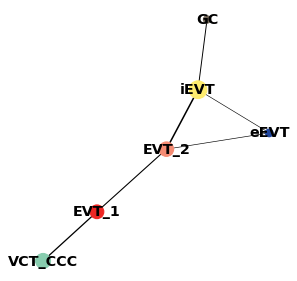



0.44
here link b/w eEVT and EVT_2 is stronger than b/w eEVT and iEVT
this tree be visualised in the correct topology without GC being detached


--> added 'pos', the PAGA positions (adata.uns['paga'])


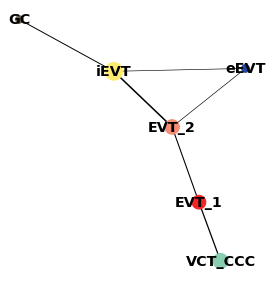



0.45
here link b/w eEVT and EVT_2 is stronger than b/w eEVT and iEVT
this tree be visualised in the correct topology without GC being detached


--> added 'pos', the PAGA positions (adata.uns['paga'])


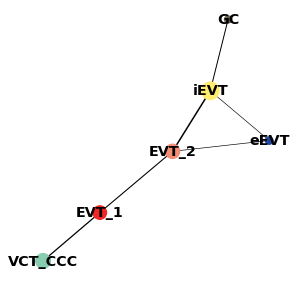

--> added 'pos', the PAGA positions (adata.uns['paga'])




0.46
here link b/w eEVT and EVT_2 is stronger than b/w eEVT and iEVT
this tree be visualised in the correct topology without GC being detached


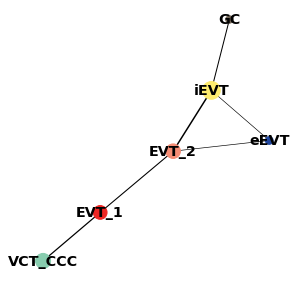

--> added 'pos', the PAGA positions (adata.uns['paga'])




0.47
here link b/w eEVT and EVT_2 is stronger than b/w eEVT and iEVT
this tree be visualised in the correct topology without GC being detached


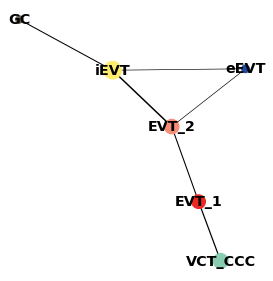

--> added 'pos', the PAGA positions (adata.uns['paga'])




0.48


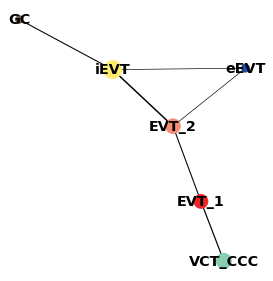

--> added 'pos', the PAGA positions (adata.uns['paga'])




0.49


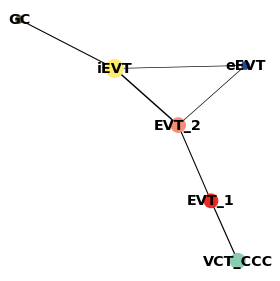

--> added 'pos', the PAGA positions (adata.uns['paga'])




0.5


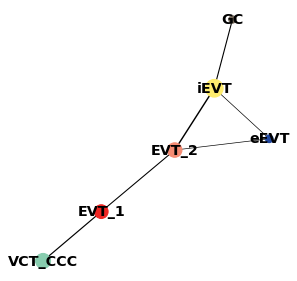

--> added 'pos', the PAGA positions (adata.uns['paga'])




0.51


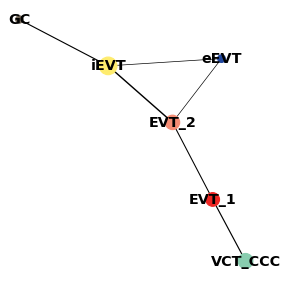

--> added 'pos', the PAGA positions (adata.uns['paga'])




0.52


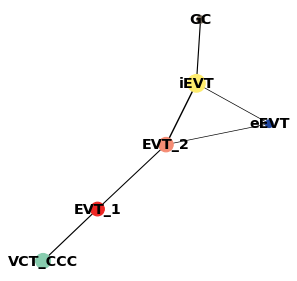

--> added 'pos', the PAGA positions (adata.uns['paga'])




0.53


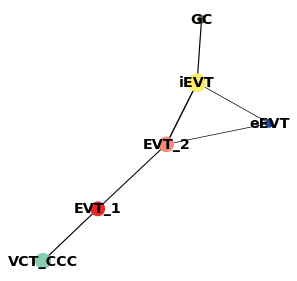

--> added 'pos', the PAGA positions (adata.uns['paga'])




0.54


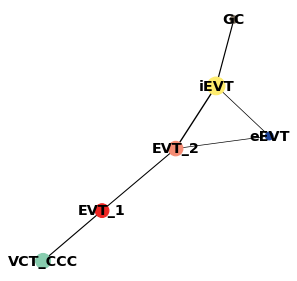

--> added 'pos', the PAGA positions (adata.uns['paga'])




0.55


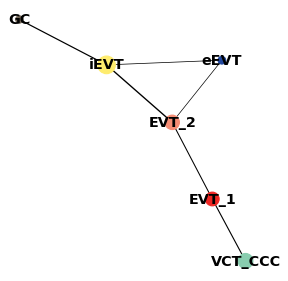

--> added 'pos', the PAGA positions (adata.uns['paga'])




0.56


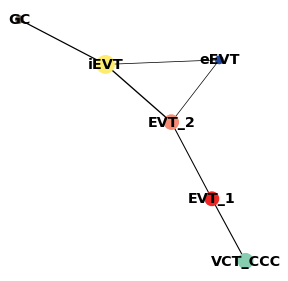

--> added 'pos', the PAGA positions (adata.uns['paga'])




0.57


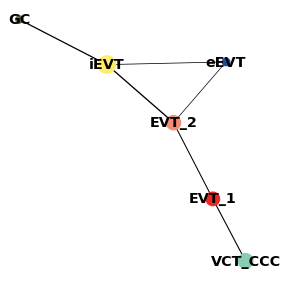

--> added 'pos', the PAGA positions (adata.uns['paga'])




0.58


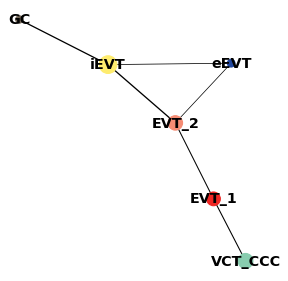

--> added 'pos', the PAGA positions (adata.uns['paga'])




0.59


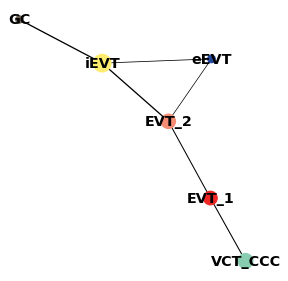

--> added 'pos', the PAGA positions (adata.uns['paga'])




0.6


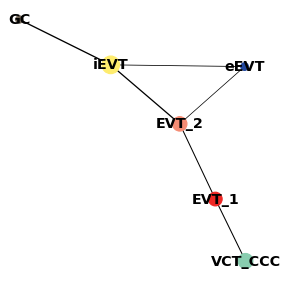

--> added 'pos', the PAGA positions (adata.uns['paga'])




0.61


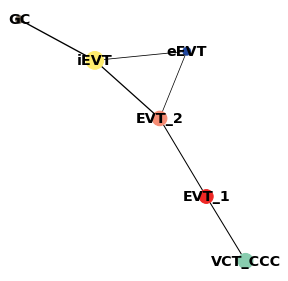

--> added 'pos', the PAGA positions (adata.uns['paga'])




0.62


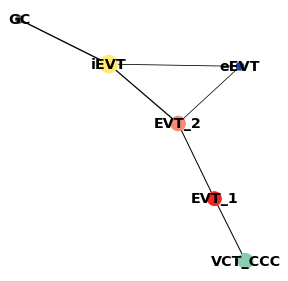

--> added 'pos', the PAGA positions (adata.uns['paga'])




0.63


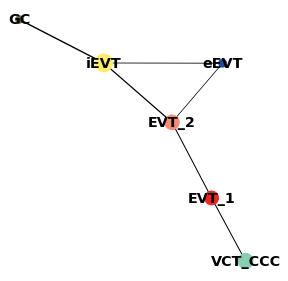

--> added 'pos', the PAGA positions (adata.uns['paga'])




0.64


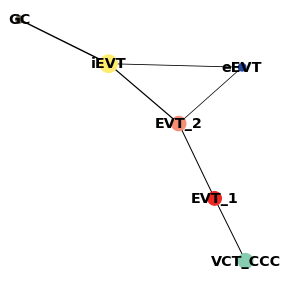

--> added 'pos', the PAGA positions (adata.uns['paga'])




0.65


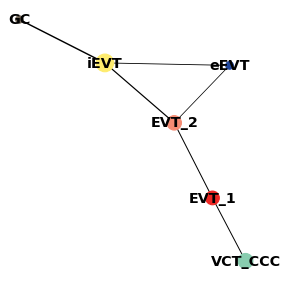

--> added 'pos', the PAGA positions (adata.uns['paga'])




0.66


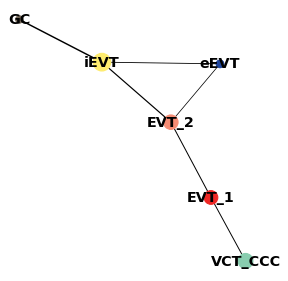

--> added 'pos', the PAGA positions (adata.uns['paga'])




0.67


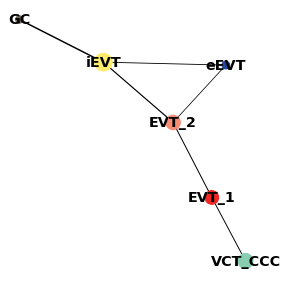

--> added 'pos', the PAGA positions (adata.uns['paga'])




0.68


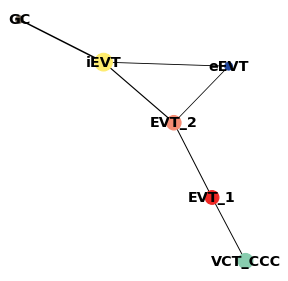



0.69


--> added 'pos', the PAGA positions (adata.uns['paga'])


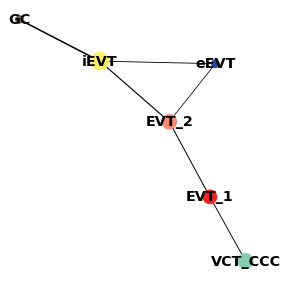



0.7


--> added 'pos', the PAGA positions (adata.uns['paga'])


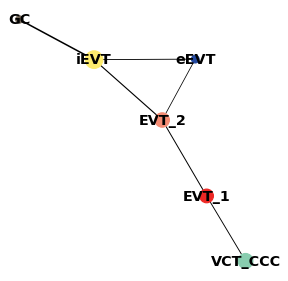

--> added 'pos', the PAGA positions (adata.uns['paga'])




0.71


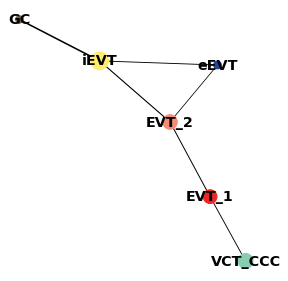

--> added 'pos', the PAGA positions (adata.uns['paga'])




0.72


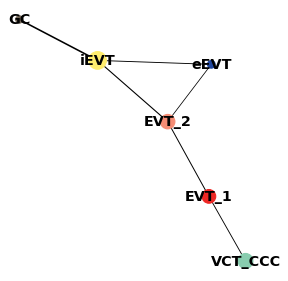

--> added 'pos', the PAGA positions (adata.uns['paga'])




0.73


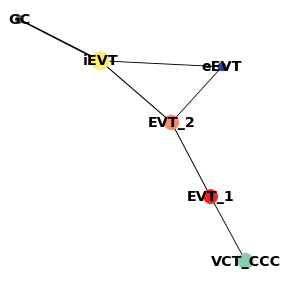

--> added 'pos', the PAGA positions (adata.uns['paga'])




0.74


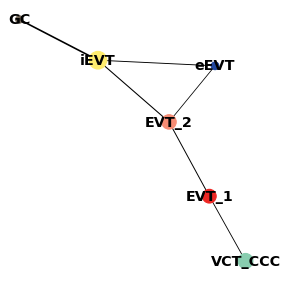

--> added 'pos', the PAGA positions (adata.uns['paga'])




0.75


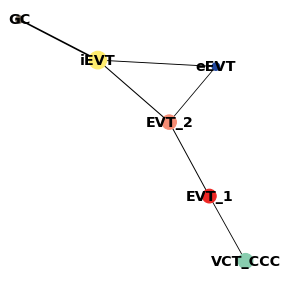

--> added 'pos', the PAGA positions (adata.uns['paga'])




0.76


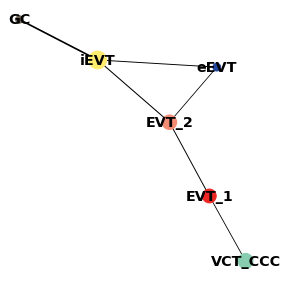

--> added 'pos', the PAGA positions (adata.uns['paga'])




0.77


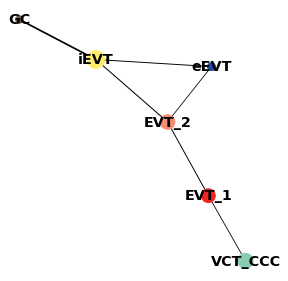

--> added 'pos', the PAGA positions (adata.uns['paga'])




0.78


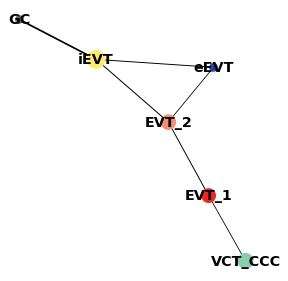

--> added 'pos', the PAGA positions (adata.uns['paga'])




0.79


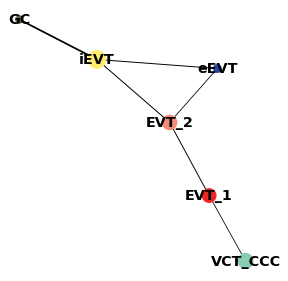

--> added 'pos', the PAGA positions (adata.uns['paga'])




0.8


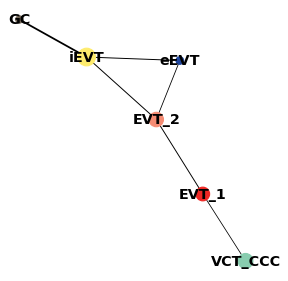

--> added 'pos', the PAGA positions (adata.uns['paga'])




0.81


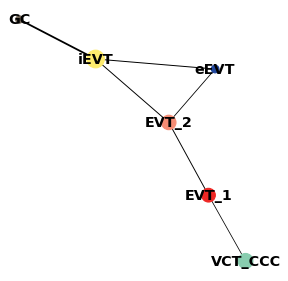

--> added 'pos', the PAGA positions (adata.uns['paga'])




0.82


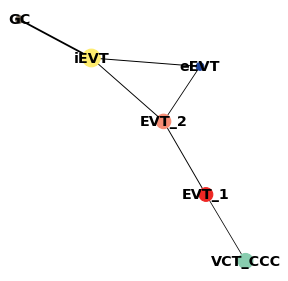

--> added 'pos', the PAGA positions (adata.uns['paga'])




0.83


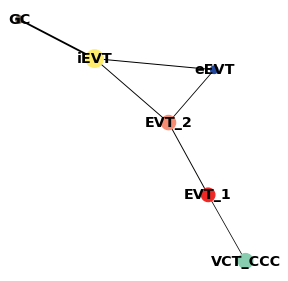

--> added 'pos', the PAGA positions (adata.uns['paga'])




0.84


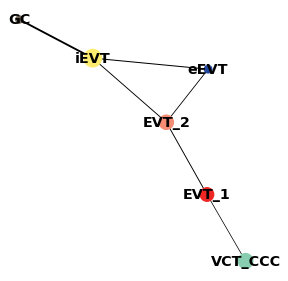

--> added 'pos', the PAGA positions (adata.uns['paga'])




0.85


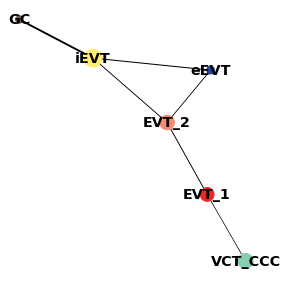

--> added 'pos', the PAGA positions (adata.uns['paga'])




0.86


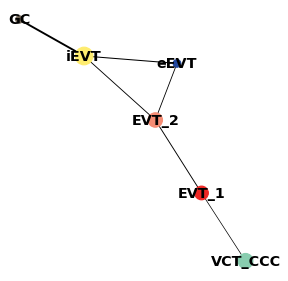

--> added 'pos', the PAGA positions (adata.uns['paga'])




0.87


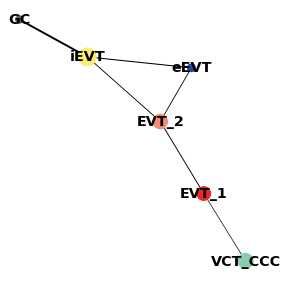

--> added 'pos', the PAGA positions (adata.uns['paga'])




0.88


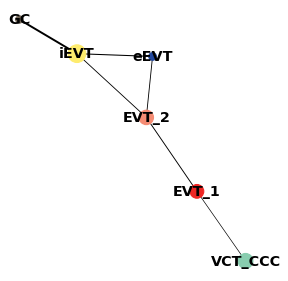

--> added 'pos', the PAGA positions (adata.uns['paga'])




0.89


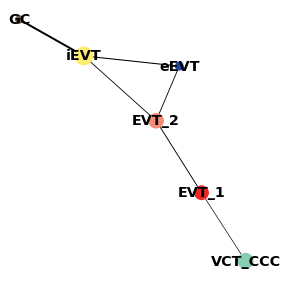

--> added 'pos', the PAGA positions (adata.uns['paga'])




0.9


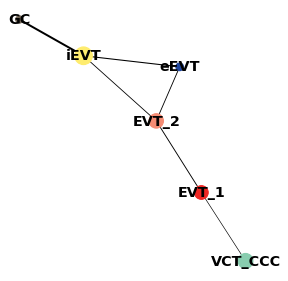

--> added 'pos', the PAGA positions (adata.uns['paga'])




0.91


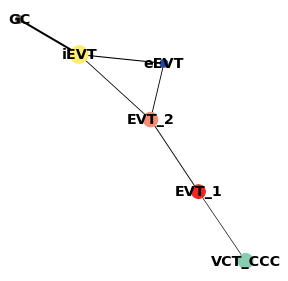

--> added 'pos', the PAGA positions (adata.uns['paga'])




0.92


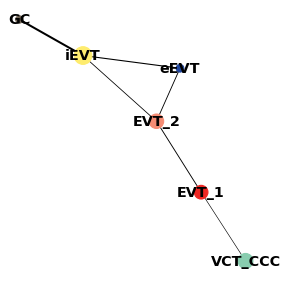



0.93


--> added 'pos', the PAGA positions (adata.uns['paga'])


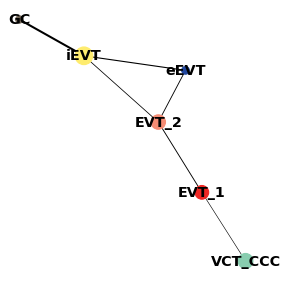



0.94


--> added 'pos', the PAGA positions (adata.uns['paga'])


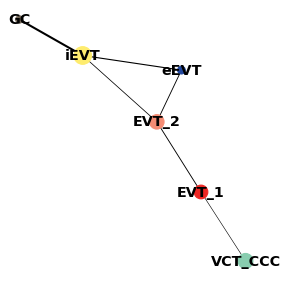



0.95


--> added 'pos', the PAGA positions (adata.uns['paga'])


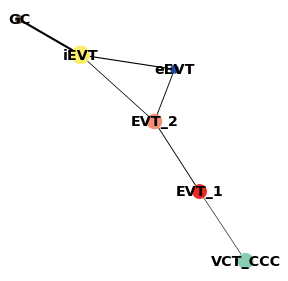

--> added 'pos', the PAGA positions (adata.uns['paga'])




0.96


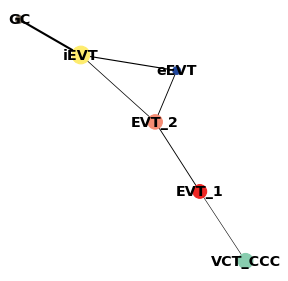

--> added 'pos', the PAGA positions (adata.uns['paga'])




0.97


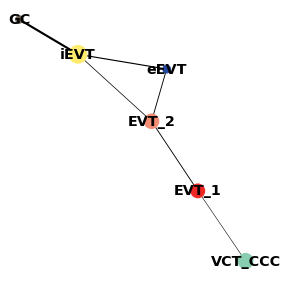

--> added 'pos', the PAGA positions (adata.uns['paga'])




0.98


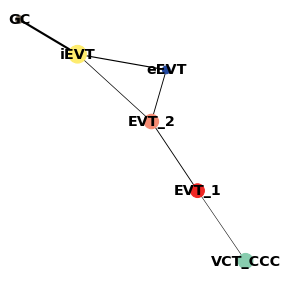

--> added 'pos', the PAGA positions (adata.uns['paga'])




0.99


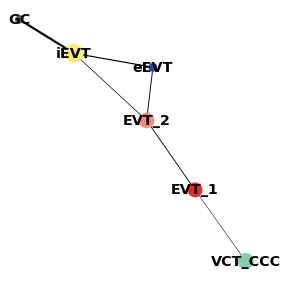

--> added 'pos', the PAGA positions (adata.uns['paga'])




1.0


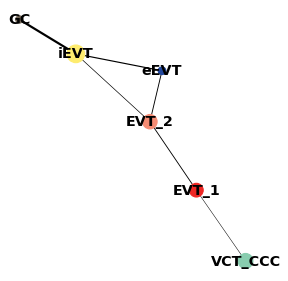

In [73]:
# which w_values yield a tree of correct topology?
w_values_correct_tree = []

for w_value in w_values:
    #adata_PAGA.uns['paga']['combined_connectivities_w_sp_' + str(w_value)]
    print(w_value)
    
    # checking where branching will start correctly
    curr_df = pd.DataFrame(adata_PAGA.uns['paga']['combined_connectivities_w_gex_' + str(w_value)].todense(),
                          index = np.unique(adata_PAGA.obs['annot_inv_troph_n_latent_8_corrected']),
                          columns = np.unique(adata_PAGA.obs['annot_inv_troph_n_latent_8_corrected']))
    if curr_df.loc['eEVT','iEVT'] < curr_df.loc['eEVT','EVT_2']:
        print('here link b/w eEVT and EVT_2 is stronger than b/w eEVT and iEVT')
        #print('conn b/w eEVT and EVT_2:', curr_df.loc['eEVT','EVT_2'])
        #print('conn b/w eEVT and iEVT:', curr_df.loc['eEVT','iEVT'])
        #print('conn b/w iEVT and GC:', curr_df.loc['GC','iEVT'])
        
        # further, can this tree be visualised in the correct topology without GC being detached?
        if curr_df.loc['GC','iEVT'] > curr_df.loc['eEVT','iEVT']:
            print('this tree be visualised in the correct topology without GC being detached')
            w_values_correct_tree.append(w_value)
            
            
    # with 22.02.2022 results with l_init = 29
    sc.pl.paga(adata_PAGA, color=['annot_inv_troph_n_latent_8_corrected'], 
               solid_edges='combined_connectivities_w_gex_' + str(w_value),
               edge_width_scale=0.2, node_size_scale=1, 
               threshold=0.2, random_state=0,
              frameon=False, 
             #save = '_combined_20211129.pdf'
              )
    
    print('\n')
    

In [94]:
w_values_correct_tree

[0.16,
 0.17,
 0.18,
 0.19,
 0.2,
 0.21,
 0.22,
 0.23,
 0.24,
 0.25,
 0.26,
 0.27,
 0.28,
 0.29,
 0.3,
 0.31,
 0.32,
 0.33,
 0.34,
 0.35,
 0.36,
 0.37,
 0.38,
 0.39,
 0.4,
 0.41,
 0.42,
 0.43,
 0.44,
 0.45,
 0.46,
 0.47]

--> added 'pos', the PAGA positions (adata.uns['paga'])


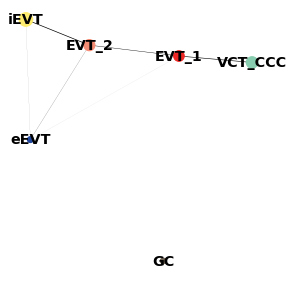

In [74]:
# same as above (paga conn) but just rescaled to a different max value (to be comparable to spatail cov table values)
sc.pl.paga(adata_PAGA, color=['annot_inv_troph_n_latent_8_corrected'], solid_edges='combined_connectivities_w_gex_0.0',
           edge_width_scale=0.5/8, node_size_scale=0.6, threshold=0.01, random_state=0,
          frameon=False, save = '_PAGA_only_sp_cov.pdf')

In [75]:
adata_PAGA.uns['paga'].keys()

dict_keys(['connectivities', 'connectivities_tree', 'groups', 'pos', 'combined_connectivities_w_gex_0.0', 'combined_connectivities_w_gex_0.01', 'combined_connectivities_w_gex_0.02', 'combined_connectivities_w_gex_0.03', 'combined_connectivities_w_gex_0.04', 'combined_connectivities_w_gex_0.05', 'combined_connectivities_w_gex_0.06', 'combined_connectivities_w_gex_0.07', 'combined_connectivities_w_gex_0.08', 'combined_connectivities_w_gex_0.09', 'combined_connectivities_w_gex_0.1', 'combined_connectivities_w_gex_0.11', 'combined_connectivities_w_gex_0.12', 'combined_connectivities_w_gex_0.13', 'combined_connectivities_w_gex_0.14', 'combined_connectivities_w_gex_0.15', 'combined_connectivities_w_gex_0.16', 'combined_connectivities_w_gex_0.17', 'combined_connectivities_w_gex_0.18', 'combined_connectivities_w_gex_0.19', 'combined_connectivities_w_gex_0.2', 'combined_connectivities_w_gex_0.21', 'combined_connectivities_w_gex_0.22', 'combined_connectivities_w_gex_0.23', 'combined_connectiviti

# Plotting a tree representative of the correct topology that is derived for w values (GEX contribution) between 0.16 and 0.47

--> added 'pos', the PAGA positions (adata.uns['paga'])


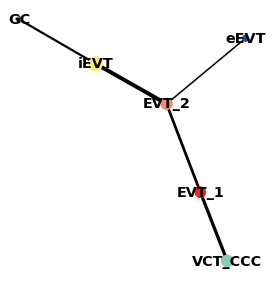

In [76]:
sc.pl.paga(adata_PAGA, color=['annot_inv_troph_n_latent_8_corrected'], solid_edges='combined_connectivities_w_gex_0.4',
           edge_width_scale=0.5, node_size_scale=0.6, threshold=0.35, random_state=0,
          frameon=False, 
           save = '_combined_20220222_w_gex_0.4.pdf'
          )